# Ranking

Ranking Evaluation form query `document:functional`

In [ ]:
expect_rank = [
    {"lang": "Haskell",      "rank": 1},
    {"lang": "Elixir",       "rank": 2},
    {"lang": "Scala",        "rank": 3},
    {"lang": "R",            "rank": 4},
    {"lang": "Rust",         "rank": 5},
    {"lang": "Python",       "rank": 6},
    {"lang": "TypeScript",   "rank": 7},
    {"lang": "JavaScript",   "rank": 8},
    {"lang": "Kotlin",       "rank": 9},
    {"lang": "Swift",        "rank": 10},
    {"lang": "Lua",          "rank": 11},
    {"lang": "Ruby",         "rank": 12},
    {"lang": "Apache Groovy", "rank": 13},
]

# Neue Testfallstruktur mit Unterscheidung für Standard/DisMax
# Kombinierte und aktualisierte Testfälle
lang_rankings = [
    # Bestehende Testfälle
    {
        "query": "functional",
        "field": "document",
        "standard_query": "document:functional",#
        "expected_langs": expect_rank
    },
]
param_configs = [
    {
        "name": "Standard (Baseline)",
        "params": {},
        # Standardabfrage ohne spezielle Parameter (Baseline).
    },
    {
        "name": "DisMax Basic",
        "params": {
            "defType": "dismax", 
            "qf": "document paradigm title"  # Felder für die Query: document, paradigm, title
        },
    },
        {
        "name": "EDisMax Basic",
        "params": {
            "defType": "edismax",
            "qf": "document paradigm title"  # Felder für die Query: document, paradigm, title
        },
    },
        # Boost-Varianten
    {
        "name": "EDisMax mit Paradigm-Boost",
        "params": {
            "defType": "edismax", 
            "qf": "paradigm^10 document"  # paradigm-Feld mit Boost 10, document ohne Boost
        },
    },
    {
        "name": "EDisMax mit document-Boost",
        "params": {
            "defType": "edismax", 
            "qf": "paradigm document^10"  # document-Feld mit Boost 10, paradigm ohne Boost
        },
    },
    {
        "name": "EDisMax mit Paradigm-Boost-Both",
        "params": {
            "defType": "edismax", 
            "qf": "paradigm^10 document^2"  # paradigm-Feld mit Boost 100, document ohne Boost
        },
    },
    {
        "name": "EDisMax mit Phrase-Boost und Tie",
        "params": {
            "defType": "edismax", 
            "qf": "paradigm document",  # paradigm-Feld mit Boost 10, document mit Boost 3
            # Dokumente, die diese exakte Phrase im paradigm-Feld enthalten, erhalten den vollen Boost von 20
            "pf": "paradigm^20",  # Phrase-Boost auf paradigm mit Boost 20
            "tie": "0.3"  # Tie-Breaker-Parameter auf 0.3
        },
    },
    {
        "name": "EDisMax mit Boost Query",
        "params": {
            "defType": "edismax", 
            "qf": "paradigm document",  # paradigm-Feld mit Boost 10, document mit Boost 3
            # In diesem Fall erhält jedes Dokument, bei dem das Feld "paradigm" 
            # den Begriff "functional" enthält, einen deutlichen Boost-Faktor von 5 für seinen Relevanz-Score.
            "bq": "paradigm:functional^5"  # Boost Query: paradigm:functional mit Boost 5
        },
    },
    {
        "name": "EDisMax mit Boost Query-High",
        "params": {
            "defType": "edismax", 
            "qf": "paradigm document",  # paradigm-Feld mit Boost 10, document mit Boost 3
            # In diesem Fall erhält jedes Dokument, bei dem das Feld "paradigm" 
            # den Begriff "functional" enthält, einen deutlichen Boost-Faktor von 5 für seinen Relevanz-Score.
            "bq": "paradigm:functional^50"  # Boost Query: paradigm:functional mit Boost 5
        },
    },
    {
        "name": "EDisMax mit Boost Query and normal Boost",
        "params": {
            "defType": "edismax", 
            "qf": "paradigm document^10",  # paradigm-Feld mit Boost 10, document mit Boost 3
            # In diesem Fall erhält jedes Dokument, bei dem das Feld "paradigm" 
            # den Begriff "functional" enthält, einen deutlichen Boost-Faktor von 5 für seinen Relevanz-Score.
            "bq": "paradigm:functional^5"  # Boost Query: paradigm:functional mit Boost 5
        },
    },
    {
        "name": "EDisMax mit Boost Query und Tie",
        "params": {
            "defType": "edismax", 
            "qf": "paradigm document",  # paradigm-Feld mit Boost 10, document mit Boost 3
            # In diesem Fall erhält jedes Dokument, bei dem das Feld "paradigm" 
            # den Begriff "functional" enthält, einen deutlichen Boost-Faktor von 5 für seinen Relevanz-Score.
            "bq": "paradigm:functional^5",  # Boost Query: paradigm:functional mit Boost 5
            "tie": "0.3"
        },
    },
    {
        "name": "EDisMax mit MM 100%",
        "params": {
            "defType": "edismax", 
            "qf": "paradigm document",  # paradigm-Feld mit Boost 10, document mit Boost 3
            # Wenn dieser Parameter auf 100% gesetzt ist, müssen alle Begriffe der Benutzeranfrage 
            # in einem Dokument vorhanden sein, damit es in den Suchergebnissen erscheint.
            "mm": "100%"  # Minimum-Should-Match auf 100%
        },
    }
]

In [ ]:
from core import evaluate_case, EvaluationResult
import json
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

# Beispiel: core und Konfiguration
cores = ["ProgLang24_4"]

all_results = []

# Für jede Parameter-Konfiguration durchführen
for config in param_configs:
    results = []
    print(f"\n\n=== Evaluierung mit {config['name']} ===\n")
    
    for core in cores:
        solr_url = f'http://10.248.16.116:8983/solr/{core}/select'
        for case in lang_rankings:
            query_display = case.get('query') if config['params'].get('defType') else case.get('standard_query')
            print(f"Evaluating case: {query_display} on core: {core} with {config['name']}")
            
            # Parameter für diese Evaluation anwenden
            result: EvaluationResult = evaluate_case(case, solr_url, core, facet=None, **config['params'])
            
            # Hinzufügen von Informationen über die verwendeten Parameter
            result_with_config = deepcopy(result)
            result_with_config["config_name"] = config['name']
            result_with_config["config_params"] = config['params']
            
            results.append(result_with_config)
    
    # Speichern der Ergebnisse für diese Konfiguration
    with open(f"./results/results-ranking-func-{config['name'].replace(' ', '_').lower()}.json", "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    
    all_results.append({
        "config": config,
        "results": results
    })



=== Evaluierung mit Standard (Baseline) ===

Evaluating case: document:functional on core: ProgLang24_4 with Standard (Baseline)
DEBUG - Sending to Solr: {'rows': 30, 'wt': 'json', 'q': 'document:functional'}
Ranking-Abgleich:


=== Evaluierung mit DisMax Basic ===

Evaluating case: functional on core: ProgLang24_4 with DisMax Basic
DEBUG - Sending to Solr: {'rows': 30, 'wt': 'json', 'q': 'functional', 'defType': 'dismax', 'qf': 'document paradigm title'}
Ranking-Abgleich:


=== Evaluierung mit EDisMax Basic ===

Evaluating case: functional on core: ProgLang24_4 with EDisMax Basic
DEBUG - Sending to Solr: {'rows': 30, 'wt': 'json', 'q': 'functional', 'defType': 'edismax', 'qf': 'document paradigm title'}
Ranking-Abgleich:


=== Evaluierung mit EDisMax mit Paradigm-Boost ===

Evaluating case: functional on core: ProgLang24_4 with EDisMax mit Paradigm-Boost
DEBUG - Sending to Solr: {'rows': 30, 'wt': 'json', 'q': 'functional', 'defType': 'edismax', 'qf': 'paradigm^10 document'}
Ranking

/tmp/ipykernel_4662/1933184213.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(config_names, rotation=45, ha='right')


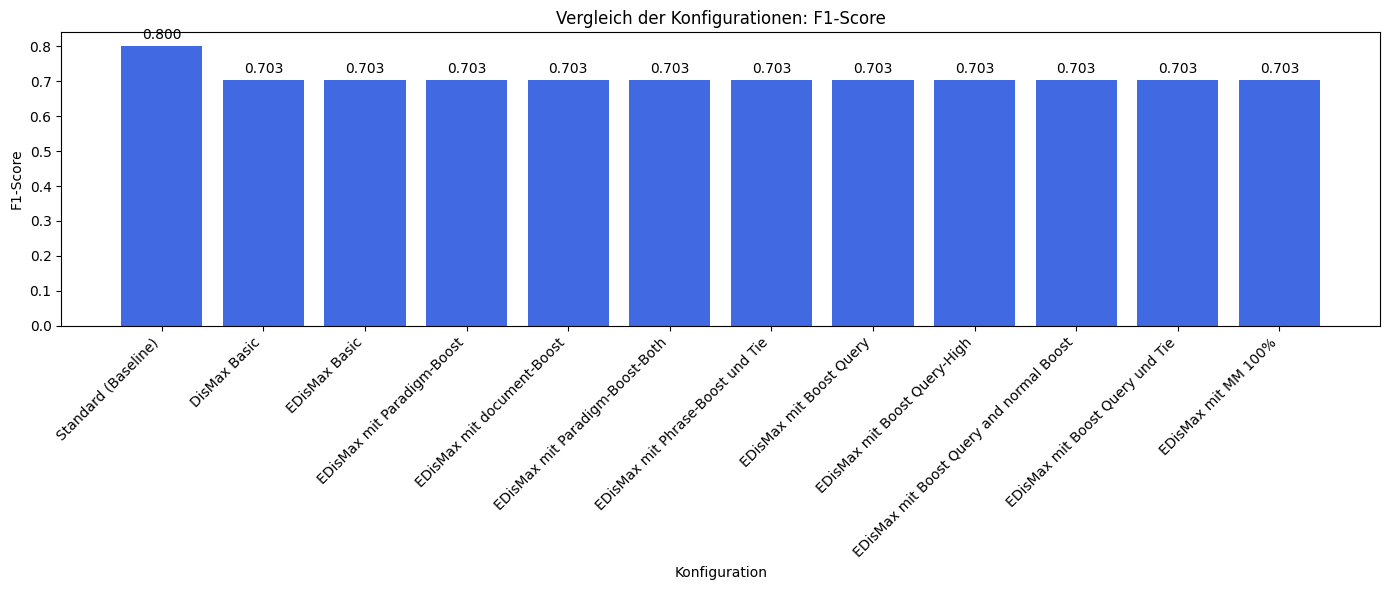

/tmp/ipykernel_4662/1933184213.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(config_names, rotation=45, ha='right')


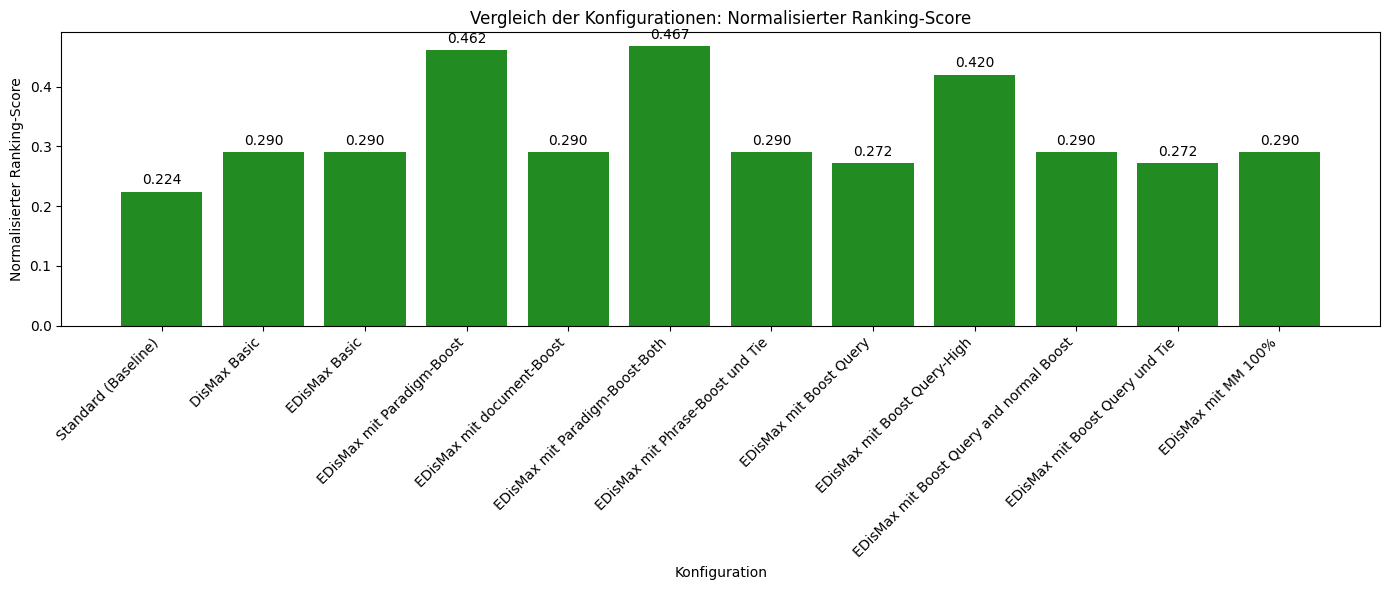

/tmp/ipykernel_4662/1933184213.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(config_names, rotation=45, ha='right')


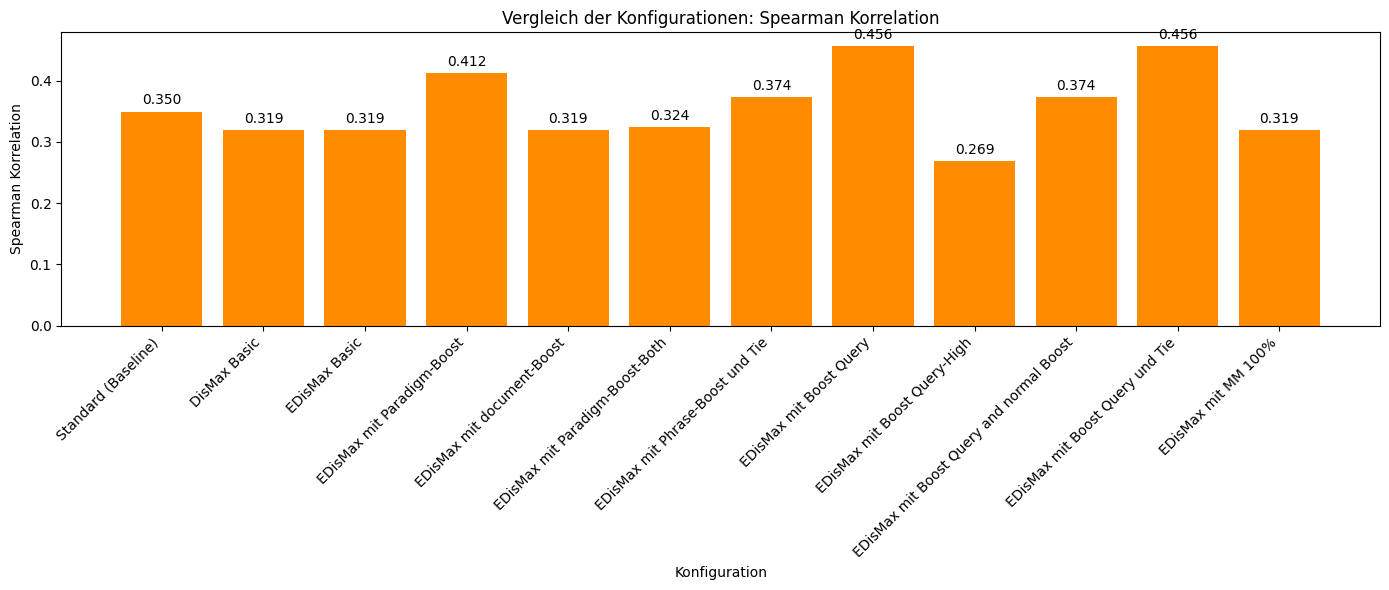

/tmp/ipykernel_4662/1933184213.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(config_names, rotation=45, ha='right')


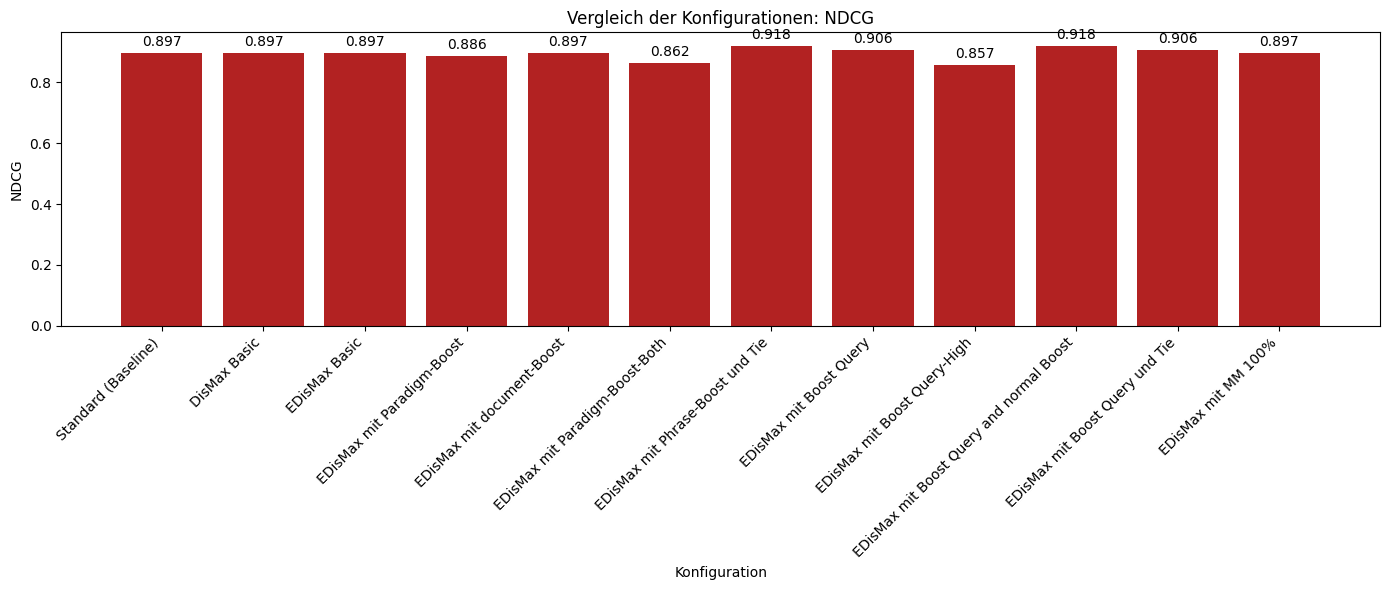

/tmp/ipykernel_4662/1933184213.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(config_names, rotation=45, ha='right')


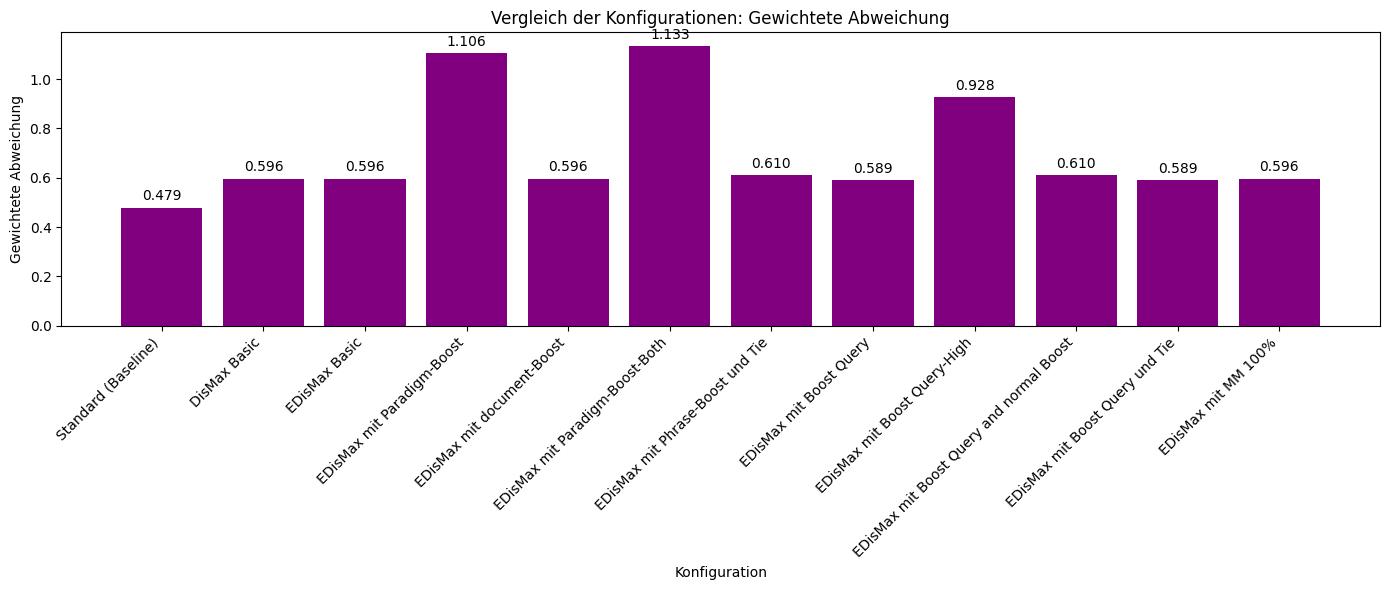

/tmp/ipykernel_4662/1933184213.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(config_names, rotation=45, ha='right')


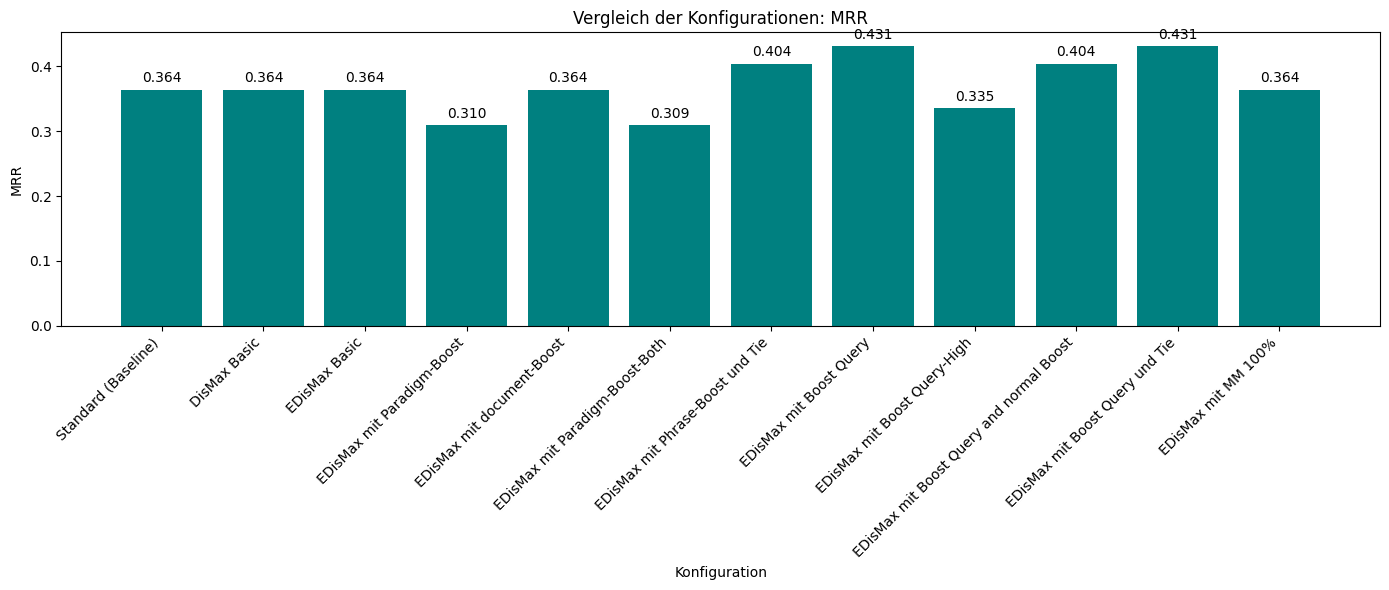

In [20]:
# Extrahiere alle Metriken für jede Konfiguration
config_names = []
avg_f1_scores = []
avg_ranking_scores = []
avg_spearman_scores = []
avg_ndcg_scores = []
avg_weighted_scores = []
avg_mrr_scores = []

for config_results in all_results:
    config_name = config_results["config"]["name"]
    config_names.append(config_name)
    
    # Berechne Durchschnittswerte für diese Konfiguration
    f1_scores = [r["s1_f1"] for r in config_results["results"]]
    ranking_scores = [r["ranking_score"] for r in config_results["results"]]
    spearman_scores = [r["ranking_score_sperman"] for r in config_results["results"]]
    ndcg_scores = [r["ranking_score_ndcg"] for r in config_results["results"]]
    weighted_scores = [r["ranking_score_weighted"] for r in config_results["results"]]
    mrr_scores = [r["ranking_score_mrr"] for r in config_results["results"]]
    
    avg_f1_scores.append(sum(f1_scores) / len(f1_scores) if f1_scores else 0)
    avg_ranking_scores.append(sum(ranking_scores) / len(ranking_scores) if ranking_scores else 0)
    avg_spearman_scores.append(sum(spearman_scores) / len(spearman_scores) if spearman_scores else 0)
    avg_ndcg_scores.append(sum(ndcg_scores) / len(ndcg_scores) if ndcg_scores else 0)
    avg_weighted_scores.append(sum(weighted_scores) / len(weighted_scores) if weighted_scores else 0)
    avg_mrr_scores.append(sum(mrr_scores) / len(mrr_scores) if mrr_scores else 0)

# Erstelle ein separates Diagramm für jeden Score
score_data = [
    {"name": "F1-Score", "values": avg_f1_scores, "color": "royalblue"},
    {"name": "Normalisierter Ranking-Score", "values": avg_ranking_scores, "color": "forestgreen"},
    {"name": "Spearman Korrelation", "values": avg_spearman_scores, "color": "darkorange"},
    {"name": "NDCG", "values": avg_ndcg_scores, "color": "firebrick"},
    {"name": "Gewichtete Abweichung", "values": avg_weighted_scores, "color": "purple"},
    {"name": "MRR", "values": avg_mrr_scores, "color": "teal"}
]

# Funktion zum Erstellen eines Balkendiagramms für einen Score
def create_score_plot(score_info, config_names):
    fig, ax = plt.subplots(figsize=(14, 6))
    
    bars = ax.bar(config_names, score_info["values"], color=score_info["color"])
    
    # Beschriftungen
    ax.set_xlabel('Konfiguration')
    ax.set_ylabel(score_info["name"])
    ax.set_title(f'Vergleich der Konfigurationen: {score_info["name"]}')
    ax.set_xticklabels(config_names, rotation=45, ha='right')
    
    # Werte anzeigen
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    fig.tight_layout()
    plt.show()

# Erstelle separate Diagramme für jeden Score
for score_info in score_data:
    create_score_plot(score_info, config_names)

Defaulting to user installation because normal site-packages is not writeable


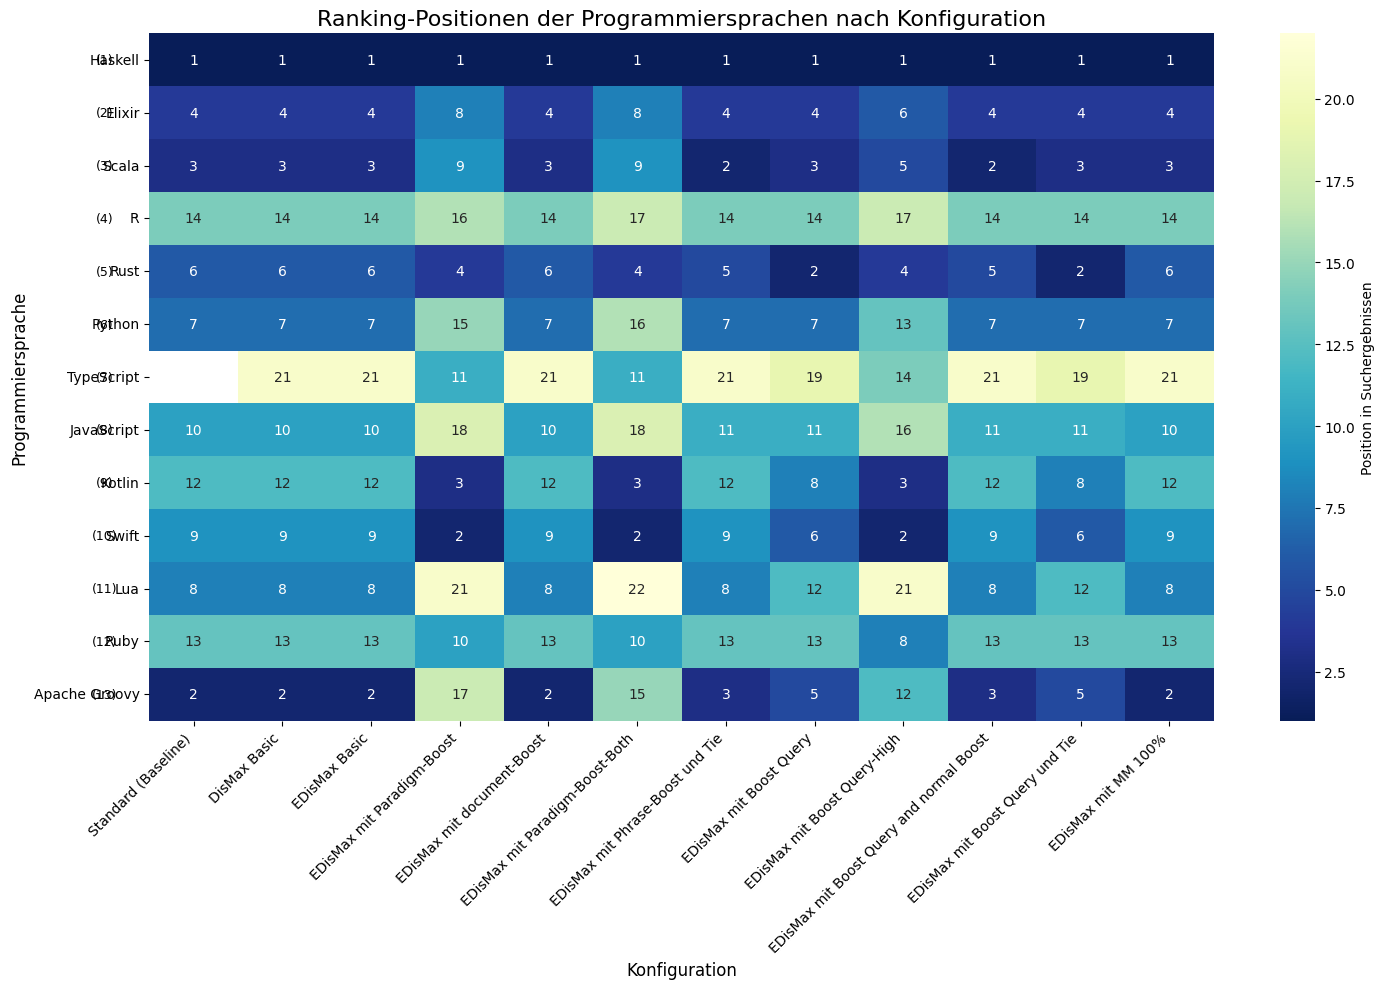

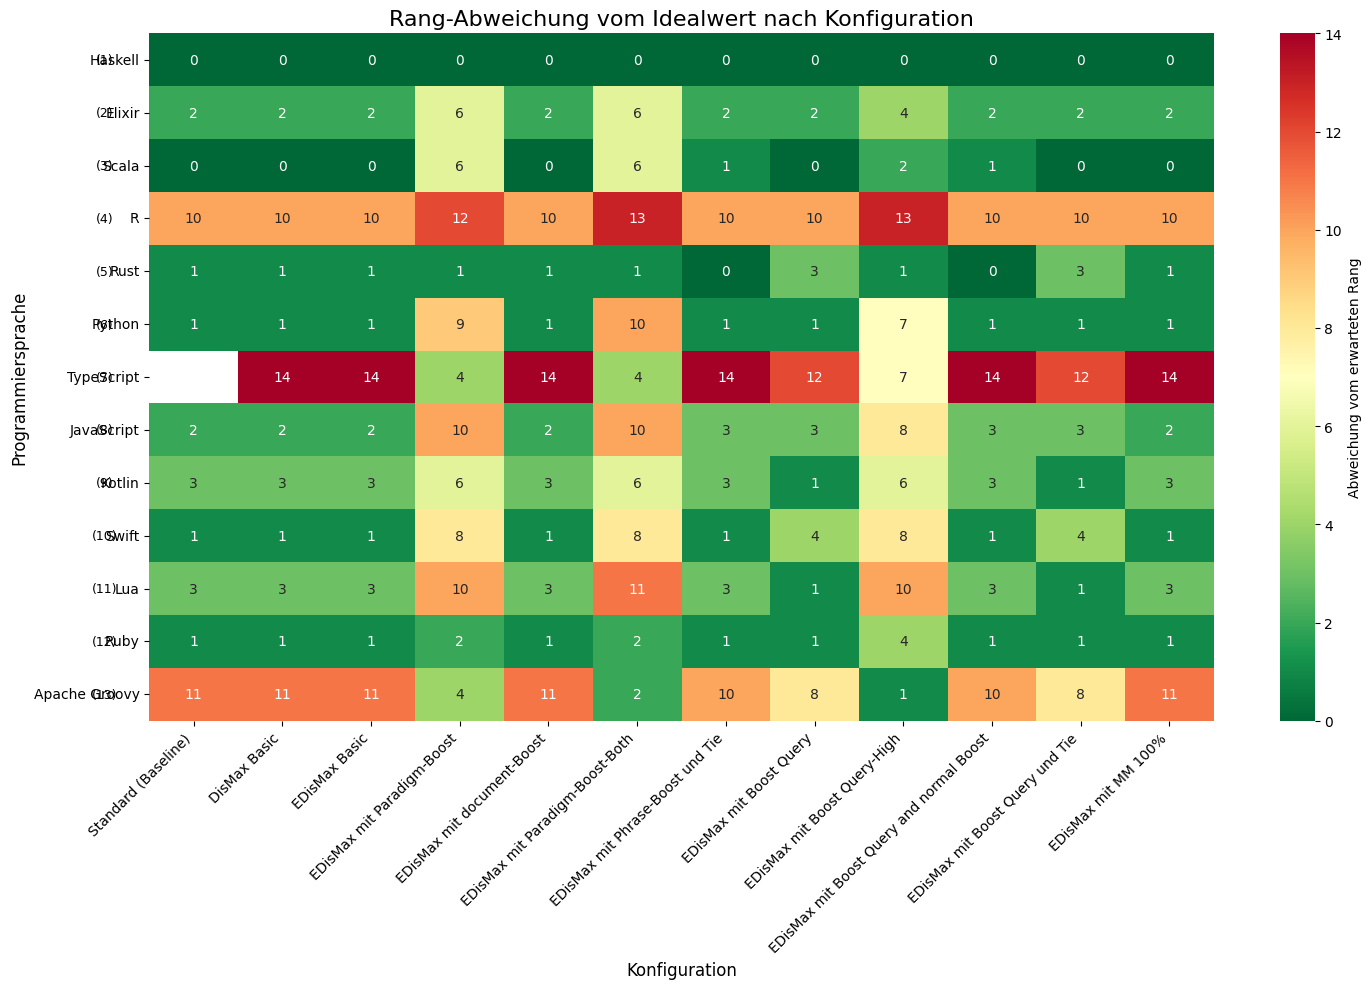

In [21]:
!pip install seaborn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Erstelle eine Struktur für die Positionen jeder Sprache in jeder Konfiguration
languages = expect_rank  # Verwende die erwarteten Sprachen
language_names = [lang["lang"] for lang in languages]
config_names = [config_result["config"]["name"] for config_result in all_results]

# Matrix für die Heatmap (Zeilen = Sprachen, Spalten = Konfigurationen)
rank_matrix = np.zeros((len(language_names), len(config_names)))
found_matrix = np.zeros((len(language_names), len(config_names)), dtype=bool)

# Fülle die Matrix mit den tatsächlichen Rangpositionen
for i, config_result in enumerate(all_results):
    # Nimm das erste Ergebnis (document:functional) für jede Konfiguration
    result = config_result["results"][0]  
    
    # Extrahiere die Rangpositionen
    for rank_info in result["ranking"]:
        lang = rank_info["lang"]
        if lang in language_names:
            idx = language_names.index(lang)
            rank_matrix[idx, i] = rank_info["actual_rank"]
            found_matrix[idx, i] = True
        
    # Markiere nicht gefundene Sprachen mit einem hohen Wert
    for j, lang in enumerate(language_names):
        if not found_matrix[j, i]:
            rank_matrix[j, i] = len(language_names) + 5  # Höher als alle anderen Positionen

# Erstelle die Heatmap
plt.figure(figsize=(15, 10))
ax = sns.heatmap(rank_matrix, 
                annot=True, 
                fmt=".0f",
                cmap="YlGnBu_r",  # Reversed colormap (niedrigere Werte = besser = dunkler)
                xticklabels=config_names,
                yticklabels=language_names,
                cbar_kws={'label': 'Position in Suchergebnissen'})

# Passe die Darstellung an
plt.title('Ranking-Positionen der Programmiersprachen nach Konfiguration', fontsize=16)
plt.xlabel('Konfiguration', fontsize=12)
plt.ylabel('Programmiersprache', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Zeige Erwartete Position neben Sprachnamen
for i, lang in enumerate(languages):
    expected_rank = lang["rank"]
    plt.text(-0.5, i + 0.5, f"({expected_rank})", 
             horizontalalignment='center', 
             verticalalignment='center',
             fontsize=9)

plt.show()

# Erstelle auch eine Heatmap mit Abweichungen vom erwarteten Rang
deviation_matrix = np.zeros_like(rank_matrix)
for i, lang in enumerate(languages):
    expected_rank = lang["rank"]
    for j in range(len(config_names)):
        if found_matrix[i, j]:
            deviation_matrix[i, j] = abs(rank_matrix[i, j] - expected_rank)
        else:
            deviation_matrix[i, j] = len(language_names)  # Hoher Wert für nicht gefundene

plt.figure(figsize=(15, 10))
ax = sns.heatmap(deviation_matrix, 
                annot=True, 
                fmt=".0f",
                cmap="RdYlGn_r",  # Rot = schlechter (höhere Abweichung), Grün = besser (niedrigere Abweichung)
                xticklabels=config_names,
                yticklabels=language_names,
                cbar_kws={'label': 'Abweichung vom erwarteten Rang'})

plt.title('Rang-Abweichung vom Idealwert nach Konfiguration', fontsize=16)
plt.xlabel('Konfiguration', fontsize=12)
plt.ylabel('Programmiersprache', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Zeige Erwartete Position neben Sprachnamen
for i, lang in enumerate(languages):
    expected_rank = lang["rank"]
    plt.text(-0.5, i + 0.5, f"({expected_rank})", 
             horizontalalignment='center', 
             verticalalignment='center',
             fontsize=9)

plt.show()